In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521632/521632 [00:03<00:00, 168319.50it/s]


In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521632/521632 [00:00<00:00, 2225276.73it/s]


In [6]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [7]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:03<00:00, 86885.79it/s]


In [8]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:00<00:00, 2888691.70it/s]


In [9]:
lifeline_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
    
    if "_reverted" in v['type_of_stake']:
        sample.append('No stakes')
    else:
        sample.append(v['type_of_stake'])
    sample.append(v['self_refree'])
        
    lifeline_raw_data.append(sample)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:00<00:00, 569275.80it/s]


In [10]:
lifeline_df = pd.DataFrame(lifeline_raw_data,columns=['success_percentage','observed','type of stake','self refree'])

In [11]:
lifeline_df

,success_percentage,observed,type of stake,self refree
0,0.0,1,No stakes,True
1,0.0,1,No stakes,True
2,0.0,1,No stakes,True
3,0.0,1,No stakes,True
4,0.0,1,No stakes,True
...,...,...,...,...
319923,0.0,1,No stakes,True
319924,0.0,1,No stakes,False
319925,0.0,1,No stakes,True
319926,0.0,1,No stakes,True


In [12]:
lifeline_df = lifeline_df[lifeline_df['success_percentage']>0.0]

In [13]:
lifeline_df['observed'].value_counts()

observed
1    92298
0    65116
Name: count, dtype: int64

In [14]:
lifeline_df['type of stake'].value_counts()

type of stake
No stakes            66978
Anti-charity         49082
Charity              20891
Money to a friend    16678
stickK                3785
Name: count, dtype: int64

In [15]:
lifeline_df['self refree'].value_counts()

self refree
True     108927
False     48487
Name: count, dtype: int64

# Survival Analysis

Full curve

In [16]:
kmf = KaplanMeierFitter()

In [17]:
T = lifeline_df['success_percentage']
E = lifeline_df['observed']

In [18]:
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 157414 total observations, 65116 right-censored observations>

<Axes: xlabel='timeline'>

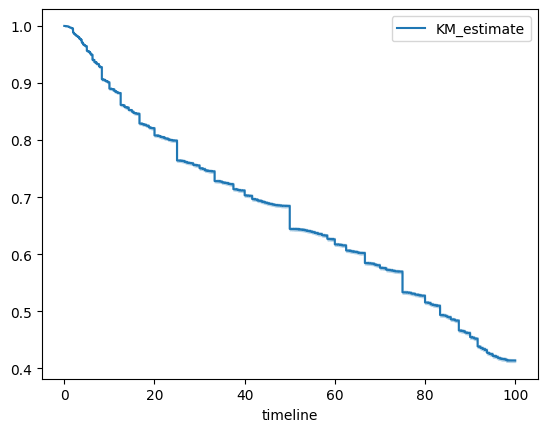

In [19]:
kmf.plot_survival_function()

Self refree

<Axes: xlabel='timeline'>

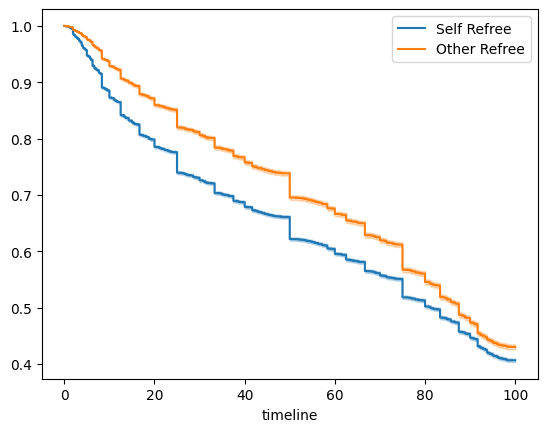

In [20]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

self_ref_df = (lifeline_df['self refree']==True)

kmf.fit(T[self_ref_df], event_observed=E[self_ref_df], label="Self Refree")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~self_ref_df], event_observed=E[~self_ref_df], label="Other Refree")
kmf.plot_survival_function(ax=ax)

In [21]:
results = logrank_test(T[self_ref_df], T[~self_ref_df], E[self_ref_df], E[~self_ref_df], alpha=.99)

results.print_summary()

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         292.05 <0.005    215.10

Type of Stake

<Axes: xlabel='timeline'>

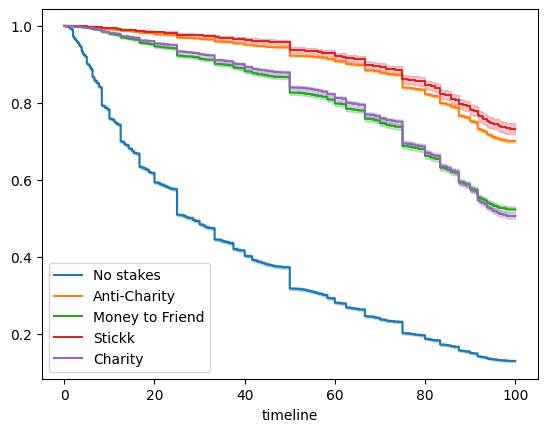

In [22]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

no_s = (lifeline_df['type of stake']=='No stakes')
AC = (lifeline_df['type of stake']=='Anti-charity')
C = (lifeline_df['type of stake']=='Charity')
MtoF = (lifeline_df['type of stake']=='Money to a friend')
S = (lifeline_df['type of stake']=='stickK')

kmf.fit(T[no_s], event_observed=E[no_s], label="No stakes")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[AC], event_observed=E[AC], label="Anti-Charity")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[MtoF], event_observed=E[MtoF], label="Money to Friend")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[S], event_observed=E[S], label="Stickk")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[C], event_observed=E[C], label="Charity")
kmf.plot_survival_function(ax=ax)

In [26]:
results = logrank_test(T[no_s], T[C], E[no_s], E[C], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       16082.30 <0.005       inf

In [27]:
results = logrank_test(T[no_s], T[AC], E[no_s], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       52733.07 <0.005       inf

In [28]:
results = logrank_test(T[C], T[AC], E[C], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2758.26 <0.005       inf

In [29]:
results = logrank_test(T[C], T[MtoF], E[C], E[MtoF], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.51 0.06      4.03

In [30]:
results = logrank_test(T[S], T[AC], E[S], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.09 <0.005     15.53

# COX Regression

In [31]:
def get_outlier(data):
    Q1 = np.percentile(data, 25, method = 'midpoint') 
    Q2 = np.percentile(data, 50, method = 'midpoint') 
    Q3 = np.percentile(data, 75, method = 'midpoint')
    
    IQR = Q3 - Q1
    
    low_lim = max(Q1 - 1.5 * IQR,min(data))
    up_lim = min(Q3 + 1.5 * IQR, max(data))
    
    return Q2, IQR, low_lim, up_lim

In [32]:
cox_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
        
    sample.append(v['stake_per_period'])
#     sample.append(v['total_stake'])
    sample.append(v['length_in_days'])
    sample.append(v['no_of_supporters'])
    sample.append(v['days_per_reporting'])
    sample.append(v['no_of_reports'])
    
        
    cox_raw_data.append(sample)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:00<00:00, 403249.28it/s]


In [33]:
# Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','total_stake','length_in_days','no_of_supporters','days_per_reporting'])

Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','length_in_days','no_of_supporters','days_per_reporting','no_of_reports'])

In [34]:
Cox_df

,success_percentage,observed,stake_per_period,length_in_days,no_of_supporters,days_per_reporting,no_of_reports
0,0.0,1,0.0,112,0,7.0,16
1,0.0,1,0.0,53,0,53.0,1
2,0.0,1,0.0,56,0,7.0,8
3,0.0,1,0.0,112,0,7.0,16
4,0.0,1,0.0,56,0,7.0,8
...,...,...,...,...,...,...,...
319923,0.0,1,0.0,56,0,7.0,8
319924,0.0,1,0.0,56,1,7.0,8
319925,0.0,1,0.0,70,0,7.0,10
319926,0.0,1,0.0,84,0,7.0,12


In [35]:
Cox_df = Cox_df[Cox_df['success_percentage']>0.0]

In [36]:
Cox_df.shape

(157414, 7)

In [37]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['stake_per_period'].to_list())

Cox_df = Cox_df[(Cox_df['stake_per_period']>=low_lim) & (Cox_df['stake_per_period']<=up_lim)]
Cox_df.shape

(139310, 7)

In [38]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['length_in_days'].to_list())

Cox_df = Cox_df[(Cox_df['length_in_days']>=low_lim) & (Cox_df['length_in_days']<=up_lim)]
Cox_df.shape

(127099, 7)

In [39]:
Q2, IQR, low_lim, up_lim = get_outlier(list(set(Cox_df['no_of_supporters'].to_list())))

Cox_df = Cox_df[(Cox_df['no_of_supporters']>=low_lim) & (Cox_df['no_of_supporters']<=up_lim)]
Cox_df.shape

(127099, 7)

In [40]:


Q2, IQR, low_lim, up_lim = get_outlier(list(set(Cox_df['days_per_reporting'].to_list())))

Cox_df = Cox_df[(Cox_df['days_per_reporting']>=low_lim) & (Cox_df['days_per_reporting']<=up_lim)]
Cox_df.shape

(127099, 7)

In [41]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['no_of_reports'].to_list())

Cox_df = Cox_df[(Cox_df['no_of_reports']>=low_lim) & (Cox_df['no_of_reports']<=up_lim)]
Cox_df.shape

(121034, 7)

In [42]:
Cox_df.shape

(121034, 7)

In [43]:
Cox_df['observed'].value_counts()

observed
1    72508
0    48526
Name: count, dtype: int64

In [44]:
cph = CoxPHFitter()

In [45]:
cph.fit(Cox_df, duration_col='success_percentage', event_col='observed')

<lifelines.CoxPHFitter: fitted with 121034 total observations, 48526 right-censored observations>

In [46]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 121034 total observations, 48526 right-censored observations>
             duration col = 'success_percentage'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 121034
number of events observed = 72508
   partial log-likelihood = -791497.26
         time fit was run = 2023-07-30 08:12:33 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
stake_per_period    -0.05       0.95       0.00            -0.05            -0.05                 0.95                 0.95
length_in_days       0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
no_of_supporters     0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
days_per_reporting  -0.04       0.96       0.00            -0.05            -0.04                 0.96                 0.96
no_of_reports        0.03       1.03       0.00             0.02             0.03                 1.02                 1.03

                     cmp to       z      p   -log2(p)
covariate                                            
stake_per_period       0.00 -118.32 <0.005        inf
length_in_days         0.00   19.82 <0.005     288.02
no_of_supporters       0.00    0.33   0.74       0.43
days_per_reporting     0.00  -31.77 <0.005     733.52
no_of_reports          0.00    9.67 <0.005      71.05
---
Concordance = 0.77
Partial AIC = 1583004.52
log-likelihood ratio test = 57935.33 on 5 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

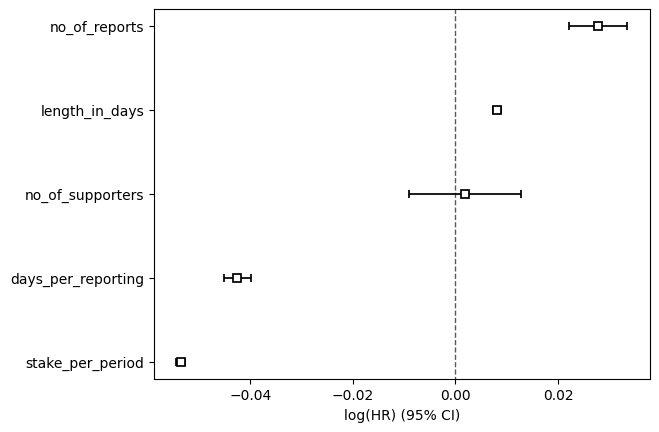

In [47]:
cph.plot()

<Axes: >

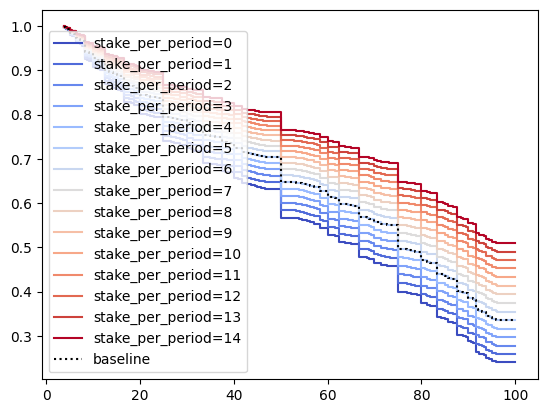

In [48]:
cph.plot_partial_effects_on_outcome(covariates='stake_per_period', values=[i for i in range(0,15,1)], cmap='coolwarm')

<Axes: >

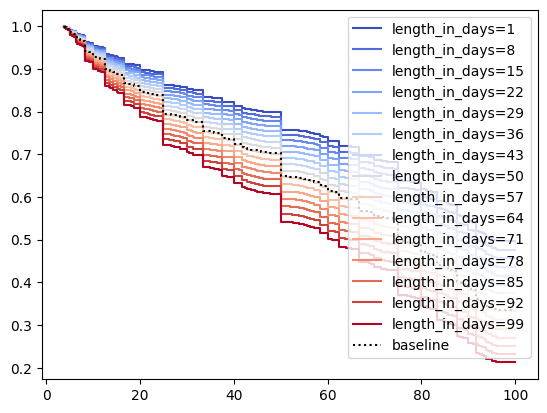

In [49]:
cph.plot_partial_effects_on_outcome(covariates='length_in_days', values=[i for i in range(1,100,7)], cmap='coolwarm')

<Axes: >

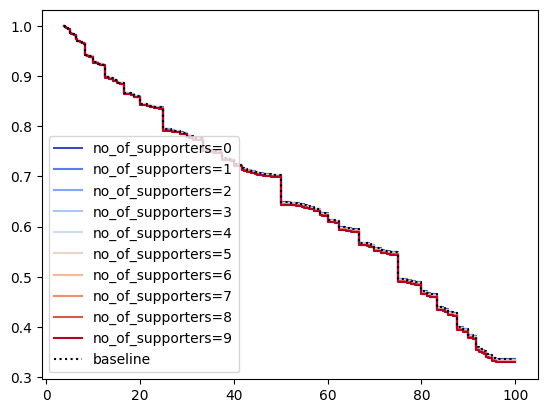

In [50]:
cph.plot_partial_effects_on_outcome(covariates='no_of_supporters', values=[i for i in range(0,10,1)], cmap='coolwarm')

<Axes: >

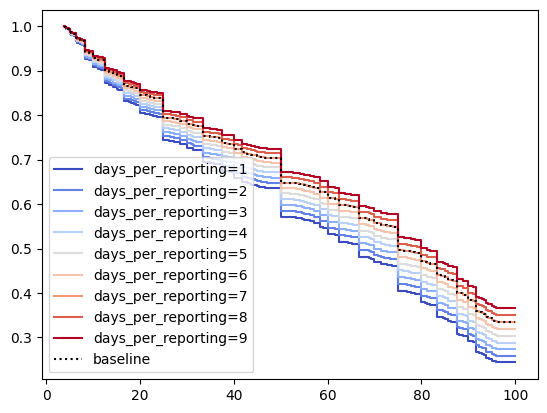

In [51]:
cph.plot_partial_effects_on_outcome(covariates='days_per_reporting', values=[i for i in range(1,10,1)], cmap='coolwarm')

<Axes: >

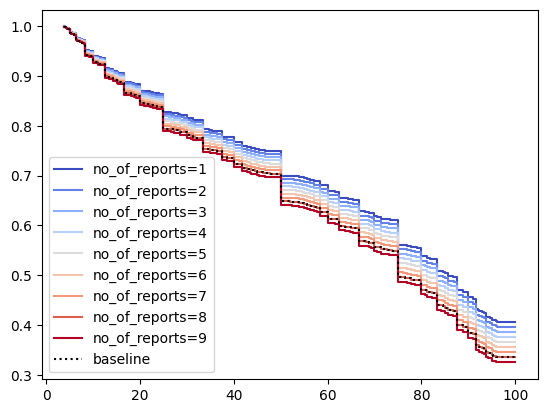

In [52]:
cph.plot_partial_effects_on_outcome(covariates='no_of_reports', values=[i for i in range(1,10,1)], cmap='coolwarm')